# Explanation and walkthrough of process_standardized_cores.py

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, brentq
warnings.filterwarnings('ignore')
from process_sumup_cores import def_models
from process_standardized_cores import process_std_main

In [2]:
# set filepaths
data_dir = "../data/PKM/"
output_dir = "../data/PKM/processed/"
domain='greenland'

metadata_file = data_dir+"cleaned-std-metadata.csv"
text_files_pattern = data_dir+"source/*.txt"  # or "*.std.txt" or "/path/to/cores/*.txt"
output_file = f"{data_dir}processed/PKM_550_830_density_depths_{domain}.csv"
    

## Step 1: Load metadata


In [3]:
# Step 1: Load metadata

# Load the '62 cores' sheet (index 1) which contains Greenland data
metadata_df = pd.read_csv(metadata_file)

# Clean up column names and data
metadta_df = metadata_df.drop(columns=['Unnamed: 0'], inplace=True)  # Remove unnecessary index column

metadata_df.head()

,Name,Longitude,Latitude,Elevation,Year,depth,Method,Citation,Unnamed: 9
0,NASA-U-1,-49.498,73.842,2369,1995,150.755,ice core section,Zoek in Kuipers Munneke et al. (2015),NaN
1,NASA-U-2,-49.498,73.842,2369,1995,NaN,NaN,checked against denstiy data for PARCA cores 2013,NaN
2,NASA-U-3,-49.498,73.842,2369,1995,NaN,NaN,checked against denstiy data for PARCA cores 2013,NaN
3,GITS-Core1,-61.095,77.000,NaN,1996,NaN,NaN,NaN,NaN
4,GITS-Core2,-61.095,77.000,NaN,1996,NaN,NaN,NaN,NaN


## Step 2: load core density profiles from textfiles

Core name from file:  D5
Metadata name:  D5


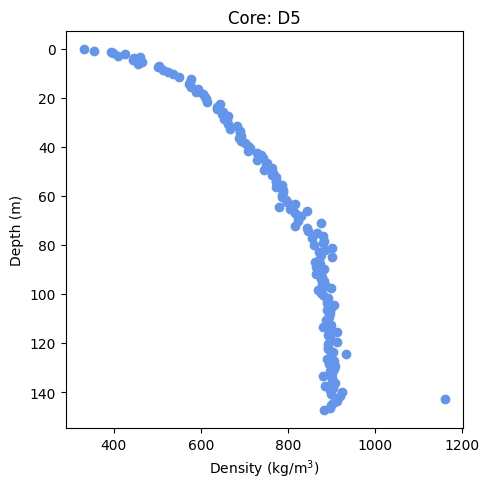

In [4]:
text_files = glob.glob(text_files_pattern)

processed_cores = []
    
# show one example, then do all
file_path = text_files[1]

# Extract core name from filename
filename = os.path.basename(file_path)
core_name = filename.replace('.std.txt', '').replace('.txt', '')


# Read the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['depth', 'density'])
    
# Find matching metadata
metadata_match = metadata_df[metadata_df['Name'].astype(str).str.lower() == core_name.lower()]
    
if metadata_match.empty:
    # Try numeric match for cases like '6345'
    try:
        core_num = float(core_name)
        metadata_match = metadata_df[metadata_df['Name'] == core_num]
    except:
        pass

if metadata_match.empty:
    print(f"Warning: No metadata found for core {core_name}")

metadata_row = metadata_match.iloc[0]

print ("Core name from file: ", core_name)
print ("Metadata name: ", metadata_match['Name'].values[0])

fig = plt.figure(figsize=(5,5))

plt.plot(data['density'], data['depth'], 'o', color='cornflowerblue')
plt.gca().invert_yaxis()
plt.xlabel("Density (kg/m$^3$)")
plt.ylabel("Depth (m)")
plt.title(f"Core: {core_name}")

plt.tight_layout()

In [5]:
# Now we will find the depths corresponding to densities 550 and 830 kg/m3

depth = data['depth'].values
density = data['density'].values
target_density = 550

models = def_models() #defined in the sumup processing script

failed=0
depth_at_rho = np.nan
best_r2 = -np.inf
best_model = None

# Remove NaN values
valid_mask = ~(np.isnan(depth) | np.isnan(density))

#If too few points, can't do fit
if valid_mask.sum() < 10:
    
    failed = 1
    print(" - Too few valid points ("+str(valid_mask.sum())+")")

# ensure they are numpy arrays
depth = np.array(depth)
density = np.array(density)

# Sort by depth, so depth is monotonically increasing (even if density is not)
sort_idx = np.argsort(depth)
depth_sorted = depth[sort_idx]
density_sorted = density[sort_idx]

# Check if target density is within the range of measured densities
min_density = density_sorted.min()
max_density = density_sorted.max()

# target density out of range
if target_density < min_density or target_density > max_density:
    failed = 1
    print("  - Target density out of range (" + str(target_density) + " not in [" + str(min_density) + ", " + str(max_density) + "])")

print("original length: " + str(len(depth)) + " vs cleaned length: " + str(len(depth_sorted)))

original length: 155 vs cleaned length: 155


### Now we're going to fit to a model. In the code, we try both power and logarithmic models, but here, we're just going to show how the fit works for a logarithmic model

Text(0.5, 1.0, 'Depth to [550, 830] kg/m³: [10.22 m, 78.33 m]')

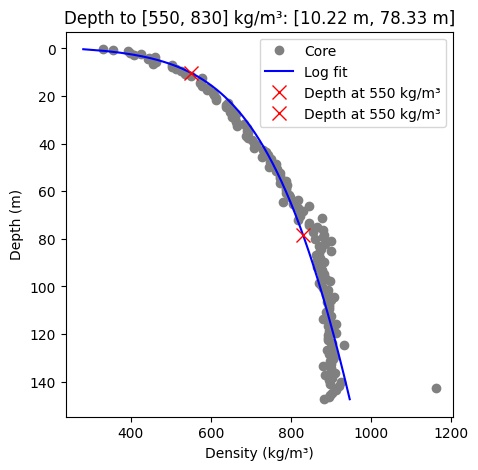

In [179]:
func, name, expression, color, func_min = models[1]

try: 

    # Fit the model
    popt, pcov = curve_fit(func, depth_sorted, density_sorted)

    # Calculate fitted values
    depth_smooth = np.linspace(depth_sorted.min(), depth_sorted.max(), 200)
    density_fit = func(depth_sorted, *popt)
    density_smooth = func(depth_smooth, *popt)

    # Calculate R²
    residuals = density_sorted - density_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((density_sorted - np.mean(density_sorted))**2)
    r2 = 1 - (ss_res / ss_tot)

    failed = 0
    
    if r2 > best_r2:
        
        best_r2 = r2
        best_model = (func, popt, name, expression, round(best_r2,3), func_min)                

except Exception as e:
    print(f"Model fitting failed for {name}: {e}")
    pass

#find the depth at the target density using the fit
try:
    depth_at_rho_550 = brentq(
        best_model[5],
        depth_sorted.min(),
        depth_sorted.max(),
        args=(*best_model[1], 550)
    )

    depth_at_rho_830 = brentq(
        best_model[5],
        depth_sorted.min(),
        depth_sorted.max(),
        args=(*best_model[1], 830)
    )
     
    
except Exception as e:
    #print(f"  - Root finding failed for best model: {best_model[2]}.")
    failed = 1

# And we can see how this fit looks by plotting it vs. the data

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(density_sorted, depth_sorted, 'o', label='Core', color='grey')

if failed == 0:
    ax.plot(density_smooth, depth_smooth, '-', label='Log fit', color='blue')

ax.plot(550, depth_at_rho_550, 'rx', label=f'Depth at {target_density} kg/m³', markersize=10)
ax.plot(830, depth_at_rho_830, 'rx', label=f'Depth at {target_density} kg/m³', markersize=10)

plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Density (kg/m³)')
plt.ylabel('Depth (m)')
plt.title(f'Depth to [550, 830] kg/m³: [{depth_at_rho_550:.2f} m, {depth_at_rho_830:.2f} m]')

### Now we can repeat this process for all points by defining functions to do this work. I'm still only doing logarithmic fits here, to limit the number of plots produced.

In [ ]:
def calculate_depth_to_density(depth, density, do_plot=True):
    """Calculate depth where density first reaches target value using interpolation"""

    target_densities = [550, 830]
    depths_at_target_densities = [np.nan,np.nan]
    failed = [0,0]
    r2 = np.nan
    fit_model = None

    models = def_models()

    # Remove NaN values
    valid_mask = ~(np.isnan(depth) | np.isnan(density))

    #If too few points, can't do fit
    if valid_mask.sum() < 10:
        
        failed = [1,1]
        print(" - Too few valid points ("+str(valid_mask.sum())+")")

        return depths_at_target_densities, failed, r2
    
    depth = np.array(depth)
    density = np.array(density)
    
    # Sort by depth
    sort_idx = np.argsort(depth)
    depth_sorted = depth[sort_idx]
    density_sorted = density[sort_idx]
    
    # Check if target density is within the range of measured densities
    min_density = density_sorted.min()
    max_density = density_sorted.max()

    if max_density > 830:
        depth_sorted_lim = depth_sorted[density_sorted >= 550]
        density_sorted_lim = density_sorted[density_sorted >= 550]

    # target density out of range
    for idx, rho_i in enumerate(target_densities):
        if rho_i < min_density or rho_i > max_density:
            failed[idx] = 1
            print("  - Target density out of range (" + str(rho_i) + " not in [" + str(min_density) + ", " + str(max_density) + "])")
        
        if all(failed):
            print("density not")
            return depths_at_target_densities, failed, r2

      # Try fit to a logarithmic or power law curve.

    #for idx, (func, name, expression, color, func_min) in enumerate(models):
    func, name, expression, color, func_min = models[1] # only log
    
    try: 

        # Fit the model
        popt, pcov = curve_fit(func, depth_sorted, density_sorted)

        # Calculate fitted values
        depth_smooth = np.linspace(depth_sorted.min(), depth_sorted.max(), 200)
        density_fit = func(depth_sorted, *popt)
        density_smooth = func(depth_smooth, *popt)
    
        # Calculate R²
        residuals = density_sorted - density_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((density_sorted - np.mean(density_sorted))**2)
        r2 = 1 - (ss_res / ss_tot)

        fit_model = (func, popt, name, expression, round(r2,3), func_min)        

    except Exception as e:
        fit_model = None
        print(f"Model fitting failed for {name}: {e}")
        pass

    if max_density > 830:

        try: 

            popt_lim, pcov_lim = curve_fit(func, depth_sorted_lim, density_sorted_lim)
            
            depth_smooth_lim = np.linspace(depth_sorted_lim.min(), depth_sorted_lim.max(), 200)
            density_fit_lim = func(depth_sorted_lim, *popt_lim)
            density_smooth_lim = func(depth_smooth_lim, *popt_lim)
            
            residuals_lim = density_sorted_lim - density_fit_lim
            ss_res_lim = np.sum(residuals_lim**2)
            ss_tot_lim = np.sum((density_sorted_lim - np.mean(density_sorted_lim))**2)
            r2_lim = 1 - (ss_res_lim / ss_tot_lim)

            fit_model_lim = (func, popt_lim, name, expression, round(r2_lim,3), func_min)
        
        except Exception as e:
            fit_model_lim = None
            pass
    else:
        fit_model_lim = None
    # try to find the depth at target density using the best model
    
    for idx, rho_i in enumerate(target_densities):


        if failed[idx] == 1:
            continue

         # Root finding to get depth at target density   

        if fit_model is not None:  
            try:
                depth_at_rho = brentq(
                    fit_model[5],
                    depth_sorted.min(),
                    depth_sorted.max(),
                    args=(*fit_model[1], rho_i)
                )
                
                depths_at_target_densities[idx] = round(depth_at_rho, 2)

            except Exception as e:
                print(f"  - Root finding failed for model: {fit_model[2]} for {rho_i}.")
                failed[idx] = 1
                pass

        if (fit_model_lim is not None) & (rho_i == 830):
            
            try:

                depth_at_rho_lim = brentq(
                    fit_model_lim[5],
                    depth_sorted_lim.min(),
                    depth_sorted_lim.max(),
                    args=(*fit_model_lim[1], rho_i)
                )            

                depths_at_830_lim = round(depth_at_rho_lim, 2)
            
            except Exception as e: 
                
                depths_at_830_lim = np.nan
                continue

    
    first_depth = [np.nan, np.nan]
    last_depth = [np.nan, np.nan]

    for idx, rho_i in enumerate(target_densities):
        
        # find first depth where density exceeds target density
        first_index = np.where(density_sorted >= rho_i)[0][0]
        first_depth[idx] = depth_sorted[first_index]
        
        #find last depth where density exceeds target density

        idxs = np.where(density_sorted >= rho_i)[0]
        
        last_index = np.nan

        for i in idxs:
            if density_sorted[i] < density_sorted[first_index]:
                last_index = i
        
        last_depth[idx] = depth_sorted[last_index] if last_index is not np.nan else np.nan

    if do_plot:

        fig,ax = plt.subplots(figsize=(5,5))
        plt.gca().invert_yaxis()

        ax.plot(density, depth, 'o', label='Core', color='grey')
        
        if fit_model is not None:
            ax.plot(density_smooth, depth_smooth, '-', label=f'{fit_model[2]}', color='blue')
        if fit_model_lim is not None:
            ax.plot(density_smooth_lim, depth_smooth_lim, 'm--', label=f'{fit_model_lim[2]} (550+)', color='orange')
            ax.plot(830, depths_at_830_lim, 'mx', markersize=10)

        ax.plot(550, first_depth[0], 'ro', markersize=4, markerfacecolor='none')
        ax.plot(550, last_depth[0], 'r^', markersize=4, markerfacecolor='none')
        ax.plot(830, first_depth[1], 'ro', markersize=4)
        ax.plot(830, last_depth[1], 'r^', markersize=4)
        ax.plot(target_densities, depths_at_target_densities, 'bx', markersize=10)

        plt.legend()
        
        plt.xlabel('Density (kg/m³)')
        plt.ylabel('Depth (m)')
        plt.title(f'Depths at 550 and 830 kg/m^3')
        plt.show()


    return depths_at_target_densities, failed, round(r2, 2)

def import_and_process_std_text_files(text_files_pattern, metadata_df):
    """Process all firn core std text files and calculate depth to 550 and 830"""
    print(f"\nProcessing text files matching pattern: {text_files_pattern}")
    
    text_files = glob.glob(text_files_pattern)
    print(f"Found {len(text_files)} text files")
    print("\n\n")
    
    processed_cores = []
    
    for file_path in text_files:
        # Extract core name from filename
        filename = os.path.basename(file_path)
        core_name = filename.replace('.std.txt', '').replace('.txt', '')
        
        try:
            # Read the text file
            data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['depth', 'density'])
            
            # Find matching metadata
            metadata_match = metadata_df[metadata_df['Name'].astype(str).str.lower() == core_name.lower()]
            
            if metadata_match.empty:
                # Try numeric match for cases like '6345'
                try:
                    core_num = float(core_name)
                    metadata_match = metadata_df[metadata_df['Name'] == core_num]
                except:
                    pass
            
            if metadata_match.empty:
                print(f"Warning: No metadata found for core {core_name}")
                continue
            
            metadata_row = metadata_match.iloc[0]
            
            # Calculate depth to density horizons
            depths_at_targets, failed, r2 = calculate_depth_to_density(data['depth'], data['density'])
            
            #depth_550, failed_550, r2_550 = calculate_depth_to_density(data['depth'], data['density'], 550)
            #depth_830, failed_830, r2_830 = calculate_depth_to_density(data['depth'], data['density'], 830)
            
            # Create core record
            core_record = {
                'core_name': str(metadata_row['Name']),
                'latitude': metadata_row['Latitude'],
                'longitude': metadata_row['Longitude'],
                'elevation': metadata_row.get('Elevation', np.nan),
                'year': metadata_row.get('Year', np.nan),
                'depth_to_550': depths_at_targets[0],
                'depth_to_830': depths_at_targets[1],
                'r2_550': r2,
                'r2_830': r2,
                'failed_fit_550': failed[0],
                'failed_fit_830': failed[1],
                'source': "PKM standardized cores",
                'method': metadata_row.get('Method', ''),
                'citation': metadata_row.get('Citation', ''),
                'measurement_count': len(data),
                'source_file': filename,
                "region": "Greenland"
            }
            
            processed_cores.append(core_record)
            print(f"Processed {core_name}: {len(data)} measurements, depth_550={depths_at_targets[0]}, depth_830={depths_at_targets[1]}")
            print("\n\n")
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    cores_df = pd.DataFrame(processed_cores)
    
    # fix elevation column, which includes some elevations of "X"
    cores_df['elevation'] = cores_df['elevation'].replace('X', np.nan)
    cores_df["elevation"] = cores_df["elevation"].replace('NaN', np.nan)
    cores_df["elevation"] = cores_df["elevation"].astype(float)

    print(f"\nProcessed {len(cores_df)} cores successfully")
    
    return cores_df

df = import_and_process_std_text_files(text_files_pattern, metadata_df)

# Debugging

plotting


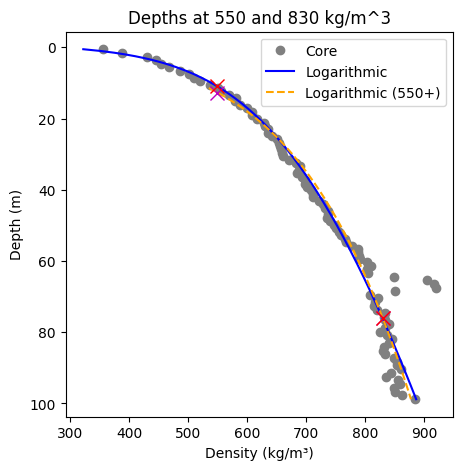

In [152]:
# def calculate_depth_to_density(depth, density, do_plot=True):
#     """Calculate depth where density first reaches target value using interpolation"""
text_files = glob.glob(text_files_pattern)

processed_cores = []

file_path = text_files[52]

# Extract core name from filename
filename = os.path.basename(file_path)
core_name = filename.replace('.std.txt', '').replace('.txt', '')

# Read the text file
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['depth', 'density'])

# Find matching metadata
metadata_match = metadata_df[metadata_df['Name'].astype(str).str.lower() == core_name.lower()]

if metadata_match.empty:
    # Try numeric match for cases like '6345'
    try:
        core_num = float(core_name)
        metadata_match = metadata_df[metadata_df['Name'] == core_num]
    except:
        pass
    
    if metadata_match.empty:
        print(f"Warning: No metadata found for core {core_name}")

    metadata_row = metadata_match.iloc[0]

depth = data['depth'].values
density = data['density'].values

target_densities = [550, 830]
depths_at_target_densities = [np.nan,np.nan]
failed = [0,0]
r2 = np.nan
fit_model = None

models = def_models()

# Remove NaN values
valid_mask = ~(np.isnan(depth) | np.isnan(density))

#If too few points, can't do fit
if valid_mask.sum() < 10:
    
    failed = [1,1]
    print(" - Too few valid points ("+str(valid_mask.sum())+")")

depth = np.array(depth)
density = np.array(density)

# Sort by depth
sort_idx = np.argsort(depth)
depth_sorted = depth[sort_idx]
density_sorted = density[sort_idx]

# Check if target density is within the range of measured densities
min_density = density_sorted.min()
max_density = density_sorted.max()

if max_density > 830:
    depth_sorted_lim = depth_sorted[density_sorted >= 550]
    density_sorted_lim = density_sorted[density_sorted >= 550]

# target density out of range
for idx, rho_i in enumerate(target_densities):
    if rho_i < min_density or rho_i > max_density:
        failed[idx] = 1
        print("  - Target density out of range (" + str(rho_i) + " not in [" + str(min_density) + ", " + str(max_density) + "])")

    # Try fit to a logarithmic or power law curve.

#for idx, (func, name, expression, color, func_min) in enumerate(models):
func, name, expression, color, func_min = models[1] # only log

try: 

    # Fit the model
    popt, pcov = curve_fit(func, depth_sorted, density_sorted)
    popt_lim, pcov_lim = curve_fit(func, depth_sorted_lim, density_sorted_lim)

    # Calculate fitted values
    depth_smooth = np.linspace(depth_sorted.min(), depth_sorted.max(), 200)
    density_fit = func(depth_sorted, *popt)
    density_smooth = func(depth_smooth, *popt)
    
    depth_smooth_lim = np.linspace(depth_sorted_lim.min(), depth_sorted_lim.max(), 200)
    density_fit_lim = func(depth_sorted_lim, *popt_lim)
    density_smooth_lim = func(depth_smooth_lim, *popt_lim)

    # Calculate R²
    residuals = density_sorted - density_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((density_sorted - np.mean(density_sorted))**2)
    r2 = 1 - (ss_res / ss_tot)

    residuals_lim = density_sorted_lim - density_fit_lim
    ss_res_lim = np.sum(residuals_lim**2)
    ss_tot_lim = np.sum((density_sorted_lim - np.mean(density_sorted_lim))**2)
    r2_lim = 1 - (ss_res_lim / ss_tot_lim)
        
    fit_model = (func, popt, name, expression, round(r2,3), func_min)
    fit_model_lim = (func, popt_lim, name, expression, round(r2_lim,3), func_min)

except Exception as e:
    print(f"Model fitting failed for {name}: {e}")
    pass


# try to find the depth at target density using the best model
depths_at_target_densities_lim = [np.nan,np.nan]
for idx, rho_i in enumerate(target_densities):


    if failed[idx] == 1:

        continue

        # Root finding to get depth at target density    
    try:
        depth_at_rho = brentq(
            fit_model[5],
            depth_sorted.min(),
            depth_sorted.max(),
            args=(*fit_model[1], rho_i)
        )

        depth_at_rho_lim = brentq(
            fit_model_lim[5],
            depth_sorted_lim.min(),
            depth_sorted_lim.max(),
            args=(*fit_model_lim[1], rho_i)
        )            

        depths_at_target_densities_lim[idx] = round(depth_at_rho_lim, 2)
        depths_at_target_densities[idx] = round(depth_at_rho, 2)

    except Exception as e:
        print(f"  - Root finding failed for model: {fit_model[2]} for {rho_i}.")
        failed[idx] = 1
    

do_plot=True
if do_plot:

    print("plotting")
    fig,ax = plt.subplots(figsize=(5,5))
    ax.plot(density, depth, 'o', label='Core', color='grey')
    
    if fit_model is not None:
        ax.plot(density_smooth, depth_smooth, '-', label=f'{fit_model[2]}', color='blue')
    if fit_model_lim is not None:
        ax.plot(density_smooth_lim, depth_smooth_lim, '--', label=f'{fit_model_lim[2]} (550+)', color='orange')
        ax.plot(target_densities, depths_at_target_densities_lim, 'mx', markersize=10)

    ax.plot(target_densities, depths_at_target_densities, 'rx', markersize=10)

    plt.legend()
    plt.gca().invert_yaxis()
    plt.xlabel('Density (kg/m³)')
    plt.ylabel('Depth (m)')
    plt.title(f'Depths at 550 and 830 kg/m^3')
    plt.show()



In [147]:
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['depth', 'density'])